Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI Registration Regularizers Overview

This notebook discusses details regarding `BendingEnergyLoss` and `DiffusionLoss`.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly"
!python -c "import matplotlib" || pip install -q matplotlib

## Setup imports

In [2]:
# python imports
import math

# data science imports
import matplotlib.pyplot as plt
import numpy as np

# PyTorch imports
import torch

# MONAI imports
from monai.config import print_config
from monai.losses.deform import BendingEnergyLoss, DiffusionLoss
from monai.networks.layers.factories import Pool

print_config()

MONAI version: 1.4.dev2350
Numpy version: 1.24.4
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e54c05d7a659e4d402f5194412889779e6856cbd
MONAI __file__: /home/<username>/miniforge3/envs/tutorial/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
scipy version: 1.9.1
Pillow version: 10.1.0
Tensorboard version: 2.15.1
gdown version: 4.7.1
TorchVision version: 0.16.0
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.7.0
transformers version: 4.35.0
mlflow version: 2.8.0
pynrrd version: 0.4.2
clearml version: 1.13.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies


## Definitions

In this section, we provide the definitions of diffusion loss and bending energy loss in the 3D case. 

Let $\Omega \subseteq \mathbb{R}^3$ be the image domain on which moving and fixed images are defined.

The diffusion loss is given by $$\begin{align*} R_\mathrm{diffusion} & = \frac{1}{|\Omega|} \sum_{\mathbf{p} \in \Omega} ||\nabla \mathbf{u} (\mathbf{p})||^2 \\ & = \frac{1}{|\Omega|} \sum_{\mathbf{p} \in \Omega} \left [ \left( \frac{\partial \mathbf{u} (\mathbf{p})}{\partial x} \right)^2 + \left( \frac{\partial \mathbf{u} (\mathbf{p})}{\partial y} \right)^2 + \left( \frac{\partial \mathbf{u} (\mathbf{p})}{\partial z} \right)^2 \right ], \end{align*}$$

where $$\nabla \mathbf{u} (\mathbf{p}) = \begin{bmatrix} \frac{\partial \mathbf{u} (\mathbf{p})}{\partial x} & \frac{\partial \mathbf{u} (\mathbf{p})}{\partial y} & \frac{\partial \mathbf{u} (\mathbf{p})}{\partial z} \end{bmatrix}$$ denotes the spatial gradient of the dense displacement field (DDF) $\mathbf{u}$ at voxel $\mathbf{p}$.

The bending energy loss is given by $$\begin{align*} R_\mathrm{bending} & = \frac{1}{|\Omega|} \sum_{\mathbf{p} \in \Omega} ||\nabla^2 \mathbf{u} (\mathbf{p})||^2 \\ & = \frac{1}{|\Omega|} \sum_{\mathbf{p} \in \Omega} \left [ \left( \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial x^2} \right)^2 + \left( \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial y^2} \right)^2 + \left( \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial z^2} \right)^2 + 2 \left( \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial x \partial y} \right)^2 + 2 \left( \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial y \partial z} \right)^2 + 2 \left( \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial z \partial x} \right)^2 \right ], \end{align*}$$

where $$\nabla^2 \mathbf{u} (\mathbf{p}) = \begin{bmatrix} \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial x^2} & \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial x \partial y} & \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial x \partial z} \\ \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial y \partial x} & \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial y^2} & \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial y \partial z} \\ \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial z \partial x} & \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial z \partial y} & \frac{\partial^2 \mathbf{u} (\mathbf{p})}{\partial z^2} \end{bmatrix}$$ denotes the Hessian matrix of the dense displacement field (DDF) $\mathbf{u}$ at voxel $\mathbf{p}$.

Central finite difference is used to estimate the spatial gradients, i.e.,

$$\frac{\partial \mathbf{u} (\mathbf{p})}{\partial x} \approx \frac{1}{2} [\mathbf{u} ((p_x + 1, p_y, p_z)) - \mathbf{u} ((p_x - 1, p_y, p_z)) ],$$

$$\frac{\partial \mathbf{u} (\mathbf{p})}{\partial y} \approx \frac{1}{2} [\mathbf{u} ((p_x, p_y + 1, p_z)) - \mathbf{u} ((p_x, p_y - 1, p_z)) ], \tag{1}$$

$$\frac{\partial \mathbf{u} (\mathbf{p})}{\partial z} \approx \frac{1}{2} [\mathbf{u} ((p_x, p_y, p_z + 1)) - \mathbf{u} ((p_x, p_y, p_z - 1)) ].$$

The second order spatial gradients are estimated similarly.

For more details on the formulation of diffusion loss, see [VoxelMorph](https://arxiv.org/abs/1809.05231). Also see [this old article](https://doi.org/10.1109/42.796284) on the formulation of bending energy loss, and [TransMorph](https://doi.org/10.1016/j.media.2022.102615) for a side-by-side comparison of diffusion loss to bending energy loss.

## Demo

In Issue [#3485](https://github.com/Project-MONAI/MONAI/issues/3485), an observation was made that bending energy loss is not invariant to spatial resolution, i.e., the same DDF with different resolutions will have different bending energy loss. A similar observation can also be made about diffusion loss. In this section, we explore the effect of changing spatial resolution on bending energy loss and diffusion loss. For the ease of visualization, all the examples are in 2D.

Before starting, we first set up a function for visualization.

In [3]:
def plot_2d_vector_field(vector_field, downsampling):
    """
    Plot a 2D vector field given as a tensor of shape (2, H, W).

    The plot origin will be in the lower left.
    Using `x` and `y` for the rightward and upward directions respectively,
    the vector at location (x, y) in the plot image will have
    vector_field[1, y, x] as its x-component and
    vector_field[0, y, x] as its y-component.

    Adapted from:
        DeepAtlas (https://github.com/ebrahimebrahim/deep-atlas/blob/main/bending_loss_scale_test.ipynb)
    """

    downsample2d = Pool["AVG", 2](kernel_size=downsampling)

    vf_downsampled = downsample2d(vector_field.unsqueeze(0))[0]

    plt.quiver(
        vf_downsampled[1, :, :],
        vf_downsampled[0, :, :],
        angles="xy",
        scale_units="xy",
        scale=downsampling,
        headwidth=4.0,
    )


def plot_loss_by_scale(loss_by_scale, loss_by_scale_normed, bending=True):
    loss_name = "Bending energy" if bending else "Diffusion"

    loss_by_scale = np.array(loss_by_scale)
    loss_by_scale_normed = np.array(loss_by_scale_normed)
    scales = loss_by_scale[:, 0]

    plt.plot(scales, loss_by_scale[:, 1], label="not normalized")
    plt.plot(scales, loss_by_scale_normed[:, 1], label="normalized")
    plt.title(f"{loss_name} loss by scale")
    plt.xlabel("Scale")
    plt.ylabel(f"{loss_name} loss (log scale)")
    plt.yscale("log")
    plt.legend()

The follow block of code defines the function that we will use in the rest of this notebook to get losses at different spatial resolutions.

In [4]:
def get_example_loss_at_scale(s, bending=True, fix_x=False, fix_y=False, normalize=False):
    """
    Getting the specified loss at a specified scale (spatial resolution).

    Adapted from:
        DeepAtlas (https://github.com/ebrahimebrahim/deep-atlas/blob/main/bending_loss_scale_test.ipynb)

    Args:
        s: spatial resolution. When both `fix_x` and `fix_y` are set to False (default),
            the generated DDF will have shape (2, s, s).
        bending: returns bending energy loss if True else diffusion energy.
        fix_x: if True, `x_scale` is set to 32. The generated DDF will be of shape (2, s, 32).
        fix_y: if True, `y_scale` is set to 32. The generated DDF will be of shape (2, 32, s).
            If both `fix_x` and `fix_y` are True, `s` is disregarded, the generated DDF will
            be of shape (2, 32, 32).
        normalize: whether to perform normalization.
    """

    # initialize scales
    x_scale = s if not fix_x else 32
    y_scale = s if not fix_y else 32

    # create ddf
    ddf = torch.tensor(
        [
            [
                [
                    (y_scale / 32) * 2 * math.cos(2 * math.pi * (x / x_scale) * 3),
                    (x_scale / 32) * math.sin(2 * math.pi * (y / y_scale) * 5),
                ]
                for x in range(x_scale)
            ]
            for y in range(y_scale)
        ]
    ).permute((2, 0, 1))

    # initialize loss function
    if bending:
        loss_fn = BendingEnergyLoss(normalize=normalize)
    else:
        loss_fn = DiffusionLoss(normalize=normalize)

    # compute loss
    loss = loss_fn(ddf.unsqueeze(0))

    if s < 80:
        plot_2d_vector_field(ddf, 1)
        loss_name = "Bending energy" if bending else "Diffusion"
        plt.suptitle(f"{loss_name} loss at scale {s}: {loss:.2f}")
        plt.title(f"DDF shape: {ddf.numpy().shape}")
        plt.show()
    return loss.item()

### Diffusion loss

#### Equally scaling both axes

We first investigate the case where the resolutions along $x$- and $y$-axes are scaled by the same factor by letting `fix_x` and `fix_y` be `False` by default.

In [ ]:
diffusion_loss_by_scale = [
    (s, get_example_loss_at_scale(s, bending=False, normalize=False)) for s in range(32, 512, 32)
]
diffusion_loss_by_scale_normed = [
    (s, get_example_loss_at_scale(s, bending=False, normalize=True)) for s in range(32, 512, 32)
]

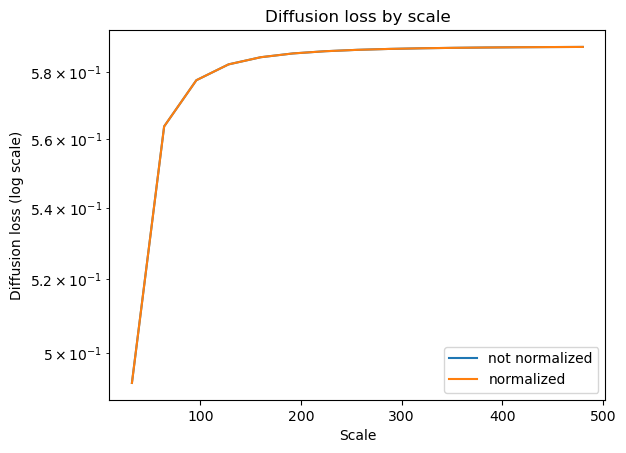

In [6]:
plot_loss_by_scale(diffusion_loss_by_scale, diffusion_loss_by_scale_normed, bending=False)
plt.show()

From the figure above, we have the following observations:
1. The two curves eventually become flat at larger scales, indicating that **diffusion loss is invariant to scale when resolutions are scaled equally along all axes**.
2. The curves fail to be flat for smaller scales. This is due to the approximation used in (1). Using central finite difference to approximate spatial gradient works well for larger spatial resolutions but fails for smaller resolutions. 
3. The curves overlap, suggesting that **enabling normalization has no effect on diffusion loss when resolutions are scaled equally along all axes**. However, this is not the case when axes are scaled by different factors. For example, we now investigate the case where we set `fix_x` to `True` to fix the resolution along the $x$-axis and only scale the $y$-axis.

#### Unequal scaling

In [ ]:
diffusion_loss_by_scale_fix_x = [
    (s, get_example_loss_at_scale(s, bending=False, fix_x=True, normalize=False)) for s in range(32, 512, 32)
]
diffusion_loss_by_scale_fix_x_normed = [
    (s, get_example_loss_at_scale(s, bending=False, fix_x=True, normalize=True)) for s in range(32, 512, 32)
]

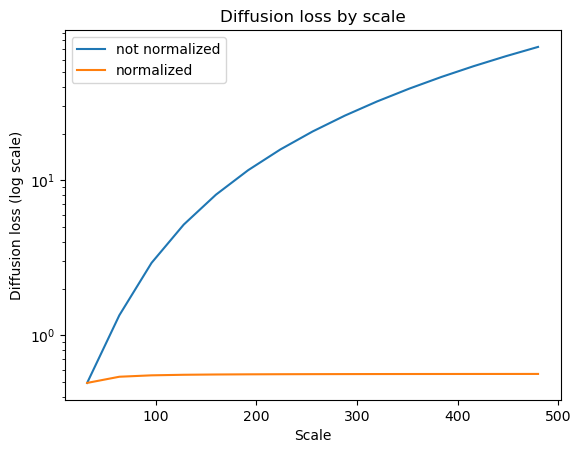

In [8]:
plot_loss_by_scale(diffusion_loss_by_scale_fix_x, diffusion_loss_by_scale_fix_x_normed, bending=False)
plt.show()

Observe that **unnormalized diffusion loss (blue) is NOT invariant to scale when resolutions are scaled unequally along different axes**. However, setting `normalize=True` (orange) makes the loss invariant to scale. Therefore, in this case, one shall consider performing normalization.

### Bending energy loss

#### Equally scaling both axes

We first investigate the case where the resolutions along $x$- and $y$-axes are scaled by the same factor by letting `fix_x` and `fix_y` be `False` by default.

In [ ]:
bending_loss_by_scale = [(s, get_example_loss_at_scale(s, bending=True, normalize=False)) for s in range(32, 512, 32)]
bending_loss_by_scale_normed = [
    (s, get_example_loss_at_scale(s, bending=True, normalize=True)) for s in range(32, 512, 32)
]

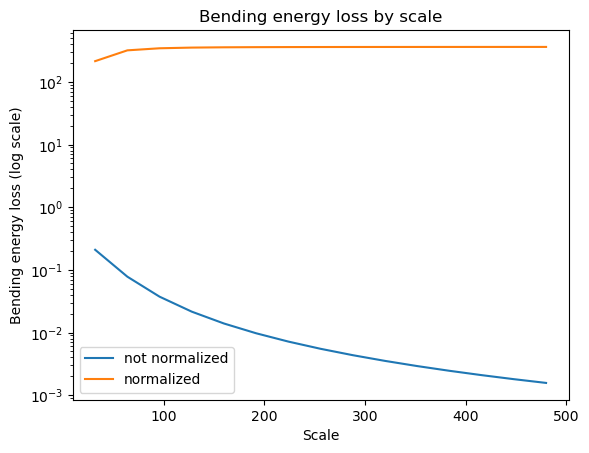

In [10]:
plot_loss_by_scale(bending_loss_by_scale, bending_loss_by_scale_normed, bending=True)
plt.show()

Observe that **unnormalized bending energy loss (blue) is NOT invariant to scale when resolutions are scaled equally along different axes**. However, when `normalize` is set to `True` (orange), the loss becomes invariant to scale. In this case, one shall consider normalization. 

In the following example, we demonstrate that this is still the case when resolution are scaled unequally along different axes by setting `fix_x` to `True`.

#### Unequal scaling

In [ ]:
bending_loss_by_scale_fix_x = [
    (s, get_example_loss_at_scale(s, bending=True, fix_x=True, normalize=False)) for s in range(32, 512, 32)
]
bending_loss_by_scale_fix_x_normed = [
    (s, get_example_loss_at_scale(s, bending=True, fix_x=True, normalize=True)) for s in range(32, 512, 32)
]

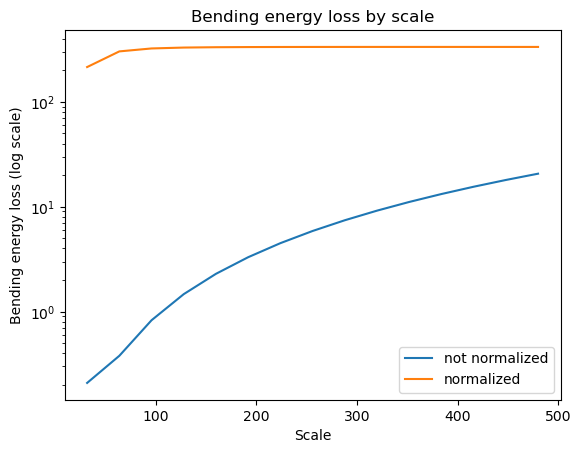

In [12]:
plot_loss_by_scale(bending_loss_by_scale_fix_x, bending_loss_by_scale_fix_x_normed, bending=True)
plt.show()

Observe that **unnormalized bending energy loss (blue) is NOT invariant to scale when resolutions are scaled unequally along different axes**. However, when `normalize` is set to `True` (orange), the loss becomes invariant to scale. In this case, one should consider normalization.

### Brief summary

In this section, we saw that unnormalized diffusion loss is sensitive to the aspect ratio of the DDF but not overall scale of the DDF. We also see that unnormalized bending energy loss is sensitive to overall scale of the DDF, making normalization even more important for bending energy loss.

|                                   | Overall image scale | Image aspect ratio |
| :-------------------------------: | :-----------------: | :----------------: |
| **(unnormalized) Bending energy** | Variant             | Variant            |
| **(unnormalized) Diffusion**      | Invariant           | Variant            |


## Usage

Finally, we provide snippets of example code for reference. For both bending energy and diffusion loss, we require the input DDF to be of shape BCH[WD] where C corresponds to the number of spatial dimensions.

In [13]:
bending_loss_fn = BendingEnergyLoss(normalize=True)
diffusion_loss_fn = DiffusionLoss(normalize=True)

# 1D
ddf_1d = torch.randn(1, 1, 16)
l_bending_1d = bending_loss_fn(ddf_1d)
l_diffusion_1d = diffusion_loss_fn(ddf_1d)

# 2D
ddf_2d = torch.randn(1, 2, 16, 16)
l_bending_2d = bending_loss_fn(ddf_2d)
l_diffusion_2d = diffusion_loss_fn(ddf_2d)

# 3D
ddf_3d = torch.randn(1, 3, 16, 16, 16)
l_bending_3d = bending_loss_fn(ddf_3d)
l_diffusion_3d = diffusion_loss_fn(ddf_3d)

## Additional readings

For additional discussions, see [#3485](https://github.com/Project-MONAI/MONAI/issues/3485) and [#7272](https://github.com/Project-MONAI/MONAI/pull/7272).